In [1]:
import numpy as np
!pip install networkx
!pip install matplotlib
!pip install pygraphviz


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


# The COMA dataset


In [2]:
import networkx as nx
import matplotlib as plt

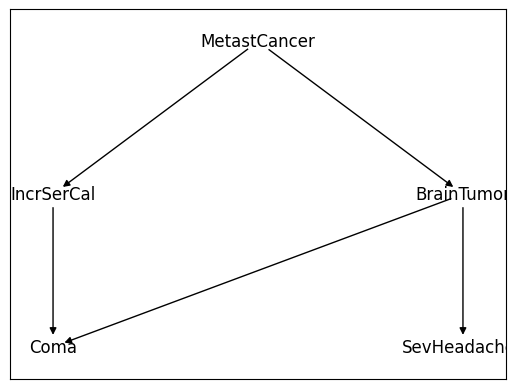

In [3]:
labels = {
    0: "MetastCancer",
    1: "IncrSerCal",
    2: "BrainTumor",
    3: "Coma",
    4: "SevHeadaches"
}
labels_reverse = {v: k for k, v in labels.items()}

edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
    (2, 4),
]



G = nx.DiGraph()
G.add_nodes_from(labels)
G.add_edges_from(edges)


pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw_networkx(
    G,
    pos = pos,
    node_shape = "o",
    labels = labels,
    arrows = True,
    node_color = "white"
)


In [4]:
def get_boundary(target_name, lbls, lrev, graph):
    target_id = lrev[target_name]

    parents = list(graph.predecessors(target_id))
    children = list(graph.successors(target_id))
    children_parents = []
    for child in children:
        children_parents.extend(list(G.predecessors(child)))

    # calculate the Markov blanket of the node
    markov_blanket = set(parents + children + children_parents)
    markov_blanket_l = [lbls[x] for x in markov_blanket]
    return markov_blanket_l

target_boundary = get_boundary("Coma", labels, labels_reverse, G)

In [91]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--num_clauses", default=10, type=int)
parser.add_argument("--T", default=10, type=int)
parser.add_argument("--s", default=10.0, type=float)
parser.add_argument("--max_included_literals", default=32, type=int)
parser.add_argument("--device", default="CPU", type=str)
parser.add_argument("--weighted_clauses", default=True, type=bool)
parser.add_argument("--epochs", default=1000, type=int)
parser.add_argument("--number-of-state-bits-ta", default=8, type=int)
parser.add_argument("--number-of-state-bits-ind", default=8, type=int)

args = parser.parse_args("")


In [92]:
from tmu.data import TMUDatasetSource

FEATURES = ["MetastCancer", "IncrSerCal", "BrainTumor", "SevHeadaches"]
TARGET = ["Coma"]

data = TMUDatasetSource().get_dataset(
    "Coma",
    cache=True,
    cache_max_age=1,
    cache_dir="data",
    features=FEATURES,
    labels=TARGET,
    shuffle=True,
    train_ratio=1000,
    test_ratio=1000,
    return_type=dict
)

2023-02-09 01:06:37,521 - tmu.data - DEBUG - Found config directory at: data. Release File: data/releases.json
2023-02-09 01:06:37,522 - tmu.data - DEBUG - Release file exists=True
2023-02-09 01:06:37,523 - tmu.data - DEBUG - Release file age: 10.39100253979365 minutes
2023-02-09 01:06:37,523 - tmu.data - DEBUG - Cache is out of date..
2023-02-09 01:06:37,922 - tmu.data - DEBUG - Writing release data to data/releases.json
2023-02-09 01:06:37,923 - tmu.data - DEBUG - Dataset directory data/2023.02.04 already exists.


In [93]:
from tools import BenchmarkTimer
from tmu.models.classification.vanilla_classifier import TMClassifier
import logging
from tqdm import tqdm

_LOGGER = logging.getLogger(__name__)


tm = TMClassifier(
    number_of_clauses=args.num_clauses,
    T=args.T,
    s=args.s,
    max_included_literals=args.max_included_literals,
    number_of_state_bits_ta=args.number_of_state_bits_ta,
    number_of_state_bits_ind=args.number_of_state_bits_ind,
    platform=args.device,
    weighted_clauses=args.weighted_clauses,
    type_iii_feedback=True
)


_LOGGER.info(f"Running {TMClassifier} for {args.epochs}")
tq = tqdm(range(args.epochs))
for epoch in tq:

    tm.fit(data["x_train"], data["y_train"])
    result = 100 * (tm.predict(data["x_test"]) == data["y_test"]).mean()

    tq.set_description(f"Accuracy: {round(result)}")

    #_LOGGER.info(f"Epoch: {epoch + 1}, Accuracy: {result:.2f}, Training Time: {benchmark1.elapsed():.2f}s, "
    #             f"Testing Time: {benchmark2.elapsed():.2f}s")



2023-02-09 01:06:39,960 - __main__ - INFO - Running <class 'tmu.models.classification.vanilla_classifier.TMClassifier'> for 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-09 01:06:39,961 - tmu.models.classification.vanilla_classifier - DEBUG - Initializing clause bank....


Accuracy: 81: 100%|██████████| 1000/1000 [02:40<00:00,  6.22it/s]


In [95]:
import pandas as pd
LITERAL_TYPES = ["Inclusion", "Exclusion"]
literal_freq = tm.literal_clause_frequency()

literal_combined_sum = np.stack(np.split(literal_freq, 2)).sum(axis=0)

weighted_literal_combined_sum = [(FEATURES[i], item) for i, item in enumerate(literal_combined_sum)]

print(weighted_literal_combined_sum)


df = pd.DataFrame(
    columns=FEATURES,
    data=np.split(literal_freq, 2)
)

# Find the two highest values in each row. exclude 0
result = df.apply(lambda x: x[x != 0].nlargest(len(target_boundary)).index.tolist(), axis=1)

for i, item in enumerate(result):
    _LOGGER.info(f"{LITERAL_TYPES[i]}:\t{sorted(item)}")
_LOGGER.info(f"Target:\t\t{sorted(target_boundary)}")

_LOGGER.info("-------------------------")
_LOGGER.info("0 = Inclusion, 1 = Exclusion")
print(df)

[('MetastCancer', 9), ('IncrSerCal', 19), ('BrainTumor', 15), ('SevHeadaches', 18)]
2023-02-09 01:09:37,297 - __main__ - INFO - Inclusion:	['IncrSerCal', 'SevHeadaches']
2023-02-09 01:09:37,298 - __main__ - INFO - Exclusion:	['BrainTumor', 'IncrSerCal']
2023-02-09 01:09:37,298 - __main__ - INFO - Target:		['BrainTumor', 'IncrSerCal']
2023-02-09 01:09:37,298 - __main__ - INFO - -------------------------
2023-02-09 01:09:37,299 - __main__ - INFO - 0 = Inclusion, 1 = Exclusion
   MetastCancer  IncrSerCal  BrainTumor  SevHeadaches
0             4           9           1            10
1             5          10          14             8
